# RGB–Rainfall Calibration Notebook

This notebook provides a **generic pipeline** for calibrating radar RGB imagery against ground station precipitation data.

**Main features:**
- Handles long historical archives (e.g., 2011–2024)
- Aggregates 2‑minute radar frames into hourly products
- Uses maximum‑intensity aggregation (suitable for extreme events)
- Builds an RGB→rainfall regression model using station data
- Produces estimated rainfall maps and saves results in `outputs/`

In [1]:
pip install numpy pandas matplotlib scikit-learn pillow pyproj scipy joblib tqdm

Note: you may need to restart the kernel to use updated packages.


## 1. Imports and configuration

In [1]:
import os, glob
import numpy as np
import pandas as pd
from PIL import Image
from pyproj import Transformer, Geod
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directories
radar_dir = '../../data/radar_sumare'
stations_csv = '../../config/SurfaceStations.csv'
grid_file = 'sumare_radar_latlon_grid.npz'
outputs_dir = 'outputs'
os.makedirs(outputs_dir, exist_ok=True)

# Radar parameters
SUMARE_RADAR_LAT = -22.955139
SUMARE_RADAR_LON = -43.248278
SUMARE_RADAR_RADIUS = 138_900  # meters
RADAR_INTERVAL_MIN = 2
STATION_INTERVAL_H = 1
IMG_WIDTH = 656 # pixels
IMG_HEIGHT = 654 # pixels

In [2]:
radar_dir_img = '../../data/radar_sumare/2011/01/17/2011_01_17_15_36__.png'
img = Image.open(radar_dir_img)
width, height = img.size
print(f"Image dimensions: {width} x {height} pixels")

Image dimensions: 656 x 654 pixels


## 2. Utility functions

In [21]:
def load_radar_composite(radar_dir, dt_utc, window_minutes=60, frame_interval=2, method='max', min_coverage=0.5):

    import glob
    from PIL import Image
    import numpy as np
    import os
    from datetime import timedelta

    # compute number of expected frames
    expected_frames = int(window_minutes / frame_interval)
    min_frames = int(expected_frames * min_coverage)

    # collect all frames within the window
    start_time = dt_utc
    end_time = dt_utc + timedelta(minutes=window_minutes)

    pattern = f"{radar_dir}/{dt_utc:%Y}/{dt_utc:%m}/{dt_utc:%d}/{dt_utc:%Y_%m_%d_}*.png"
    all_files = sorted(glob.glob(pattern))
    files_in_window = [f for f in all_files if start_time.strftime("%H_") <= os.path.basename(f)[11:14] <= end_time.strftime("%H_")]

    if len(files_in_window) < min_frames:
        return None

    imgs = []
    for f in files_in_window:
        try:
            img = Image.open(f).convert('RGB')
            imgs.append(np.array(img))
        except Exception:
            continue

    if not imgs:
        return None

    agg_func = np.max if method == 'max' else np.mean
    return agg_func(imgs, axis=0)

In [22]:
def load_hourly_radar(radar_dir, dt_utc, method='max', min_frames=15):
    """Aggregate 2‑minute radar PNGs into a single hourly composite.
    method='max' (default) preserves extreme intensity.
    Returns np.ndarray (H×W×3) or None if no data."""
    
    pattern = f"{radar_dir}/{dt_utc:%Y}/{dt_utc:%m}/{dt_utc:%d}/{dt_utc:%Y_%m_%d_%H_}*.png"
    files = sorted(glob.glob(pattern))
    if len(files) < min_frames:
        return None
    
    imgs = []
    for f in files:
        try:
            img = Image.open(f).convert('RGB')
            imgs.append(np.array(img))
        except Exception as e:
            #print(f"Skipping invalid radar frame: {os.path.basename(f)} ({e})")
            continue

    if len(imgs) == 0:
        return None

    agg_func = np.max if method == 'max' else np.mean
    return agg_func(imgs, axis=0)

def latlon_to_pixel(lat, lon, lat_grid, lon_grid):
    """Return (row,col) of the closest pixel to (lat,lon)."""
    dist = np.hypot(lat_grid - lat, lon_grid - lon)
    return np.unravel_index(np.argmin(dist), dist.shape)

def get_station_rain(df, timestamp):
    """Return precipitation (mm/h) for a given UTC hour if available."""
    try:
        return df.loc[timestamp, 'precipitation']
    except KeyError:
        return np.nan

def load_station_data(parquet_path):
    df = pd.read_parquet(parquet_path)
    df.index = pd.to_datetime(df.index, utc=True)
    return df

def extract_rgb_for_station(lat, lon, lat_grid, lon_grid, image):
    row, col = latlon_to_pixel(lat, lon, lat_grid, lon_grid)
    return tuple(image[row, col, :3])

## I) sumare_radar_latlon_grid.npz

In [5]:
import numpy as np
from pyproj import Proj, transform

proj_aeqd = Proj(proj='aeqd', lat_0=SUMARE_RADAR_LAT, lon_0=SUMARE_RADAR_LON, datum='WGS84')
proj_wgs84 = Proj(proj='latlong', datum='WGS84')

x = np.linspace(-SUMARE_RADAR_RADIUS, SUMARE_RADAR_RADIUS, IMG_WIDTH)
y = np.linspace(SUMARE_RADAR_RADIUS, -SUMARE_RADAR_RADIUS, IMG_HEIGHT)  

xx, yy = np.meshgrid(x, y)

lon_grid, lat_grid = transform(proj_aeqd, proj_wgs84, xx, yy)

np.savez("sumare_radar_latlon_grid.npz", lat=lat_grid, lon=lon_grid)

print("✅ Grid saved as sumare_radar_latlon_grid.npz")
print("lat_grid shape:", lat_grid.shape)
print("lon_grid shape:", lon_grid.shape)
print("Latitude range:", lat_grid.min(), "→", lat_grid.max())
print("Longitude range:", lon_grid.min(), "→", lon_grid.max())

/tmp/ipykernel_981/3397030662.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon_grid, lat_grid = transform(proj_aeqd, proj_wgs84, xx, yy)


✅ Grid saved as sumare_radar_latlon_grid.npz
lat_grid shape: (654, 656)
lon_grid shape: (654, 656)
Latitude range: -24.209289508909624 → -21.695158782862908
Longitude range: -44.61543500513054 → -41.881120994869455


## II) A652 (INMET) Station Data

In [23]:
# Function 

import pandas as pd

def read_station(station_file, id_station):
    station = station_file[station_file['STATION_ID'] == id_station]
    lat = station['VL_LATITUDE'].iloc[0]
    lon = station['VL_LONGITUDE'].iloc[0]
    return lat, lon


In [24]:
stations_file = pd.read_csv('../../config/SurfaceStations.csv')
A652_LAT, A652_LON = read_station(stations_file, 'A652')
print(A652_LAT, A652_LON)

-22.98833333 -43.19055555


### Testing

In [6]:
df_rain = load_station_data('../../data/ws/inmet/A652_preprocessed.parquet.gzip')
print(df_rain)

                           precipitation
2011-01-01 00:00:00+00:00            0.0
2011-01-01 01:00:00+00:00            0.0
2011-01-01 02:00:00+00:00            0.0
2011-01-01 03:00:00+00:00            0.0
2011-01-01 04:00:00+00:00            0.0
...                                  ...
2024-11-24 19:00:00+00:00            0.0
2024-11-24 20:00:00+00:00            0.0
2024-11-24 21:00:00+00:00            0.0
2024-11-24 22:00:00+00:00            0.0
2024-11-24 23:00:00+00:00            0.0

[116866 rows x 1 columns]


In [7]:
def get_positive_precipitation(df):
    return df[df['precipitation'] > 50]

In [8]:
get_positive_precipitation(df_rain)

,precipitation
2016-03-12 23:00:00+00:00,60.8
2019-03-03 22:00:00+00:00,57.6
2019-03-17 00:00:00+00:00,54.4
2019-04-08 22:00:00+00:00,71.6
2019-04-09 01:00:00+00:00,52.6
2022-04-01 02:00:00+00:00,60.4
2023-02-07 23:00:00+00:00,64.4


In [9]:
from datetime import datetime
import pytz

dt_utc = datetime(2019, 4, 9, 2, 0, 0, tzinfo=pytz.UTC)
radar_image = load_hourly_radar(radar_dir, dt_utc, min_frames=1)
print(radar_image.shape, radar_image.min(), radar_image.max())

(654, 656, 3) 0 255


In [10]:
from datetime import datetime
import pytz

dt_utc = datetime(2019, 4, 9, 1, 0, 0, tzinfo=pytz.UTC)
radar_image = load_hourly_radar(radar_dir, dt_utc)
#print(radar_image)
nonzero_pixels = np.count_nonzero(np.any(radar_image > 0, axis=-1))
total_pixels = radar_image.shape[0] * radar_image.shape[1]
print(f"{nonzero_pixels} pixels with reflectivity (>0) out of {total_pixels} total")

160482 pixels with reflectivity (>0) out of 429024 total


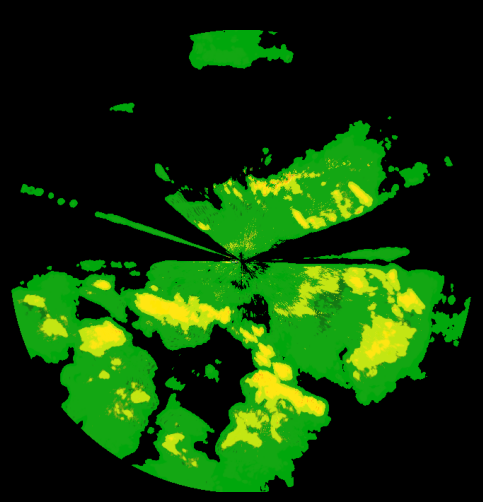

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6), facecolor='black')           
plt.imshow(radar_image)              
plt.title("Radar - 2019-04-09 02:00 UTC")  
plt.axis('off')                     
plt.show()

Station A652 pixel: row=335, col=341


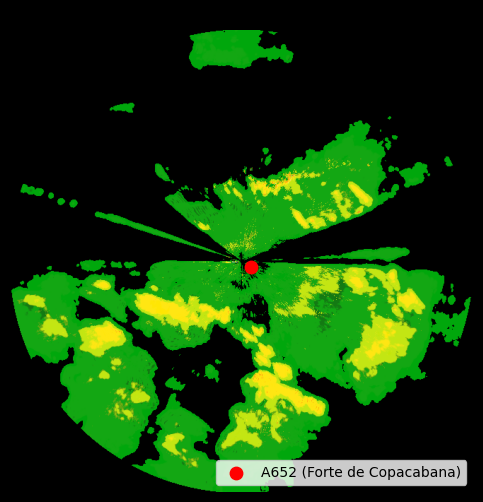

In [16]:
row, col = latlon_to_pixel(A652_LAT, A652_LON, lat_grid, lon_grid)
print(f"Station A652 pixel: row={row}, col={col}")

#  Radar image + A652 station 
plt.figure(figsize=(6, 6), facecolor='black')
plt.imshow(radar_image)
plt.scatter(col, row, color='red', marker='o', s=80, label='A652 (Forte de Copacabana)')
plt.title("Radar - 2019-04-09 02:00 UTC (Station A652 marked)")
plt.axis('off')
plt.legend(loc='lower right')
plt.show()

## 3. Build the calibration dataset

In [26]:
from datetime import timedelta
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [29]:
def build_calibration_dataset_with_zeros(station_id, station_path, lat_s, lon_s, grid_file, radar_dir, outputs_dir):
    """
    Generate a calibration dataset (RGB × precipitation) for a single station.
    """
    os.makedirs(outputs_dir, exist_ok=True)

    latlon = np.load(grid_file)
    lat, lon = latlon['lat'], latlon['lon']

    df = load_station_data(station_path)
    df = df[df['precipitation'] >= 0]  # include all precipitation values (including zeros)

    records = []
    for ts, row in tqdm(df.iterrows(), total=len(df)):
        rain = row['precipitation']
        if np.isnan(rain):
            continue

        # UTC-3
        img = load_hourly_radar(radar_dir, ts - timedelta(hours=3), method='max', min_frames=1)
        if img is None:
            continue

        rgb = extract_rgb_for_station(lat_s, lon_s, lat, lon, img)
        records.append((*rgb, rain))

    calib_df = pd.DataFrame(records, columns=['R', 'G', 'B', 'rain_mm_h'])
    out_path = os.path.join(outputs_dir, f'calibration_data_{station_id}_with_zeros.csv')
    calib_df.to_csv(out_path, index=False)
    print(f'[{station_id}] Calibration dataset: {len(calib_df)} samples saved → {out_path}')
    return calib_df


In [30]:
def build_calibration_dataset(station_id, station_path, lat_s, lon_s, grid_file, radar_dir, outputs_dir):
    """
    Generate a calibration dataset (RGB × precipitation) for a single station.
    """
    os.makedirs(outputs_dir, exist_ok=True)

    latlon = np.load(grid_file)
    lat, lon = latlon['lat'], latlon['lon']

    df = load_station_data(station_path)
    df = df[df['precipitation'] > 0]  

    records = []
    for ts, row in tqdm(df.iterrows(), total=len(df)):
        rain = row['precipitation']
        if np.isnan(rain):
            continue

        # UTC-3
        img = load_hourly_radar(radar_dir, ts - timedelta(hours=3), method='max', min_frames=1)
        if img is None:
            continue

        rgb = extract_rgb_for_station(lat_s, lon_s, lat, lon, img)
        records.append((*rgb, rain))

    calib_df = pd.DataFrame(records, columns=['R', 'G', 'B', 'rain_mm_h'])
    out_path = os.path.join(outputs_dir, f'calibration_data_{station_id}.csv')
    calib_df.to_csv(out_path, index=False)
    print(f'[{station_id}] Calibration dataset: {len(calib_df)} samples saved → {out_path}')
    return calib_df


In [32]:
# Testing
stations_df = pd.read_csv('../../config/SurfaceStations.csv')
lat, lon = read_station(stations_df, 'A652')
station_id = 'A652'
station_path = '../../data/ws/inmet/A652_preprocessed.parquet.gzip'

# with zeros (NO precipitation events)
calib_df = build_calibration_dataset_with_zeros(
    station_id,
    station_path,
    lat,
    lon,
    grid_file='sumare_radar_latlon_grid.npz',
    radar_dir='../../data/radar_sumare',
    outputs_dir='outputs'
) 

100%|██████████| 116866/116866 [7:36:58<00:00,  4.26it/s]      


[A652] Calibration dataset: 101170 samples saved → outputs/calibration_data_A652_with_zeros.csv


In [33]:
#calib_df = pd.read_csv('/home/noemi/atmoseer/notebooks/sumare_radar/outputs/calibration_data_A652.csv')
print(calib_df.head())
print(len(calib_df), "samples")

   R  G  B  rain_mm_h
0  0  0  0        0.0
1  0  0  0        0.0
2  0  0  0        0.0
3  0  0  0        0.0
4  0  0  0        0.0
101170 samples


## 4. Train and evaluate the RGB→rainfall model

In [47]:
import os

def train_and_evaluate_model(calib_df, outputs_dir='outputs', model_name='rgb2rain_model'):

    os.makedirs(outputs_dir, exist_ok=True)

    if len(calib_df) < 10:
        print('Warning: too few samples for training.')
        return None

    X = calib_df[['R','G','B']].values
    y = np.log1p(calib_df['rain_mm_h'].values)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    # --- Overall metrics ---
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    bias = np.mean(y_pred - y_true)

    print(f"\n=== Overall Performance ===")
    print(f"R²:  {r2:.3f}")
    print(f"MAE: {mae:.2f} mm/h")
    print(f"Bias (mean(pred) - mean(true)): {bias:.2f} mm/h")

    # --- Stratified analysis by rainfall intensity ---
    bins = [0, 5, 25, 50, np.inf]
    labels = ['Weak (≤5 mm/h)', 'Moderate (5–25 mm/h)', 'Heavy (25-50 mm/h)', 'Extreme (>50 mm/h)']
    groups = pd.cut(y_true, bins=bins, labels=labels, include_lowest=True)
    print('----------------------------------------------------')
    print(groups.value_counts())

    print("\n=== Performance by Rainfall Intensity ===")
    for label in labels:
        mask = (groups == label)
        if mask.sum() == 0:
            continue
        r2_bin = r2_score(y_true[mask], y_pred[mask])
        mae_bin = mean_absolute_error(y_true[mask], y_pred[mask])
        bias_bin = np.mean(y_pred[mask] - y_true[mask])
        print(f"{label:20s} → R²={r2_bin:6.3f}, MAE={mae_bin:6.2f}, Bias={bias_bin:6.2f} mm/h")

    model_path = os.path.join(outputs_dir, f'{model_name}.joblib')
    joblib.dump(model, model_path)
    print(f"\n Model saved → {model_path}")

    return model, {'R2': r2, 'MAE': mae, 'Bias': bias}

In [48]:
model, metrics = train_and_evaluate_model(calib_df, outputs_dir='outputs', model_name='rgb2rain_model_A652_with_zeros')


=== Overall Performance ===
R²:  0.072
MAE: 0.16 mm/h
Bias (mean(pred) - mean(true)): -0.05 mm/h
----------------------------------------------------
Weak (≤5 mm/h)          30187
Moderate (5–25 mm/h)      155
Heavy (25-50 mm/h)          9
Extreme (>50 mm/h)          0
Name: count, dtype: int64

=== Performance by Rainfall Intensity ===
Weak (≤5 mm/h)       → R²=-0.060, MAE=  0.11, Bias= -0.00 mm/h
Moderate (5–25 mm/h) → R²=-3.975, MAE=  8.84, Bias= -8.81 mm/h
Heavy (25-50 mm/h)   → R²=-46.433, MAE= 30.91, Bias=-30.91 mm/h

 Model saved → outputs/rgb2rain_model_A652_with_zeros.joblib


In [46]:
print(calib_df['rain_mm_h'].describe())

count    101170.000000
mean          0.134540
std           1.072216
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          64.400000
Name: rain_mm_h, dtype: float64


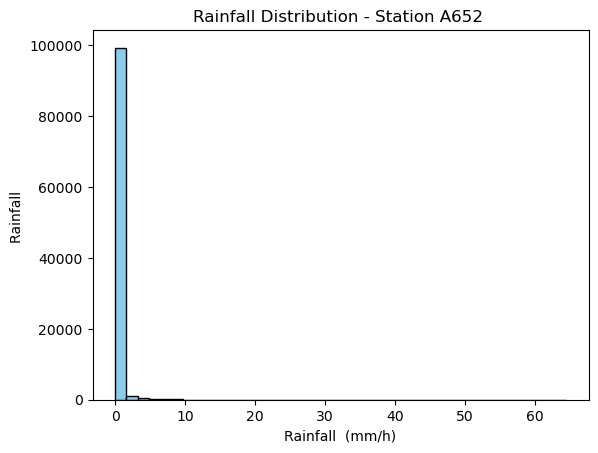

In [37]:
import matplotlib.pyplot as plt
plt.hist(calib_df['rain_mm_h'], bins=40, color='skyblue', edgecolor='k')
plt.xlabel('Rainfall  (mm/h)')
plt.ylabel('Rainfall ')
plt.title('Rainfall Distribution - Station A652 ')
plt.show()

## 5. Apply the model to a radar frame and generate rainfall map

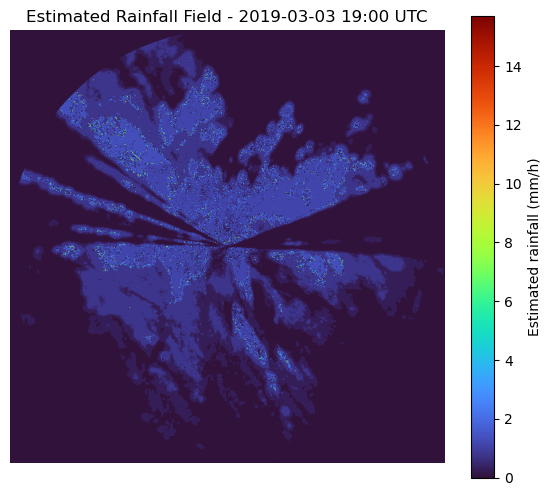

In [41]:
from datetime import datetime, timedelta
import joblib

model = joblib.load('outputs/rgb2rain_model_A652_with_zeros.joblib')

timestamp = datetime(2019, 3, 3, 19, 0)

radar_dir = '../../data/radar_sumare'
outputs_dir = 'outputs'
os.makedirs(outputs_dir, exist_ok=True)

img = load_radar_composite(
    radar_dir,
    timestamp - timedelta(hours=3),  
    window_minutes=60,               
    frame_interval=2,
    method='max'
)

if img is not None:
    rgb_flat = img.reshape(-1, 3)

    rain_flat = np.expm1(model.predict(rgb_flat))

    rain_map = rain_flat.reshape(img.shape[:2])

    np.save(os.path.join(outputs_dir, 'rain_estimated.npy'), rain_map)
    plt.figure(figsize=(7, 6))
    plt.imshow(rain_map, cmap='turbo', vmin=0, vmax=rain_map.max())
    plt.colorbar(label='Estimated rainfall (mm/h)')
    plt.title('Estimated Rainfall Field - ' + timestamp.strftime('%Y-%m-%d %H:%M UTC'))
    plt.axis('off')
    plt.savefig(os.path.join(outputs_dir, 'rain_estimated_map.png'), dpi=150)
    plt.show()

else:
    print('No radar data found for the selected timestamp.')
    

## 6. Visualization and validation

In [42]:
def plot_validation(rgb_image, rain_map, stations_df, lat_grid, lon_grid):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax1, ax2 = axes

    ax1.imshow(rgb_image.astype(np.uint8))
    ax1.set_title('Radar RGB (max reflectivity)')
    ax1.axis('off')

    im = ax2.imshow(rain_map, cmap='turbo')
    ax2.set_title('Estimated rainfall (mm/h)')
    ax2.axis('off')

    fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    for _, row in stations_df.iterrows():
        r, c = latlon_to_pixel(row['VL_LATITUDE'], row['VL_LONGITUDE'], lat_grid, lon_grid)
        ax2.plot(c, r, 'wo', markersize=5)
        ax2.text(c+3, r, row['STATION_ID'], color='white', fontsize=8)
        
    plt.tight_layout()
    plt.savefig(os.path.join(outputs_dir, 'validation_plot.png'), dpi=150)
    plt.show()

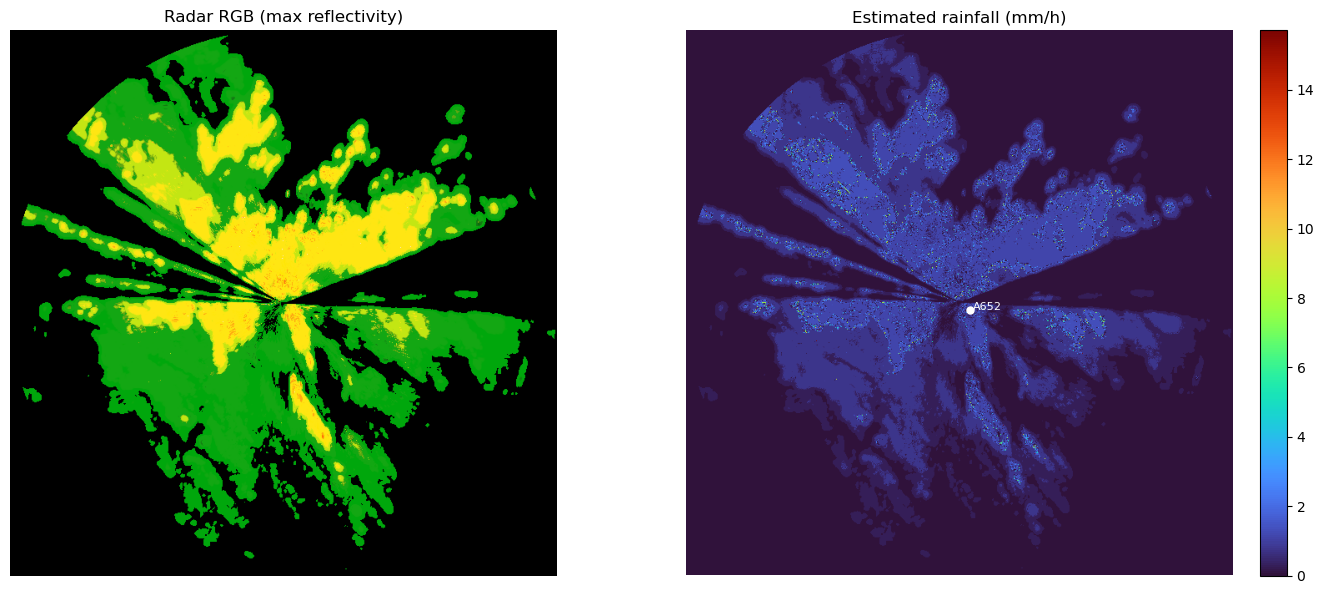

In [43]:
stations_df = pd.DataFrame([{
    'STATION_ID': 'A652',
    'VL_LATITUDE': A652_LAT,
    'VL_LONGITUDE': A652_LON
}])

latlon = np.load(grid_file)
lat_grid, lon_grid = latlon['lat'], latlon['lon']

plot_validation(img, rain_map, stations_df, lat_grid, lon_grid)